# ================================
# Canadian Crop Production Analysis
# ================================

In [1]:
library(RSQLite)
library(DBI)
library(ggplot2)
library(dplyr)

Warning message:
"package 'RSQLite' was built under R version 4.5.2"

Adjuntando el paquete: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
# Conect to SQLite
# Conexión a SQLite
con <- dbConnect(SQLite(), "FinalDB.sqlite")

# ================================
#### Create tables / Crear tablas

#### Establish a connection **con** to the RSQLite database **FinalDB.sqlite**, and create the following four tables. / Establezca una conexión **con** a la base de datos RSQLite **FinalDB.sqlite** y cree las siguientes cuatro tablas.

1.  **CROP_DATA**
2.  **FARM_PRICES**
3.  **DAILY_FX**
4.  **MONTHLY_FX**
# ================================

In [3]:
dbExecute(con, "CREATE TABLE IF NOT EXISTS CROP_DATA (
  CD_ID INTEGER, DATE INTEGER, CROP_TYPE TEXT, GEO TEXT,
  SEEDED_AREA REAL, HARVESTED_AREA REAL, PRODUCTION REAL, AVG_YIELD REAL)")
dbExecute(con, "CREATE TABLE IF NOT EXISTS FARM_PRICES (
  CD_ID INTEGER, DATE TEXT, CROP_TYPE TEXT, GEO TEXT, PRICE_PRERMT REAL)")
dbExecute(con, "CREATE TABLE IF NOT EXISTS DAILY_FX (
  DFX_ID INTEGER, DATE TEXT, FXUSDCAD REAL)")
dbExecute(con, "CREATE TABLE IF NOT EXISTS MONTHLY_FX (
  DFX_ID INTEGER, DATE TEXT, FXUSDCAD REAL)")

[1] 0

[1] 0

[1] 0

[1] 0

# ================================
#### Read Datasets and load your tables in database / Leer conjuntos de datos y cargar sus tablas en la base de datos
# ================================

In [4]:
crop <- read.csv("Annual_Crop_Data.csv")
farm <- read.csv("Monthly_Farm_Prices.csv")
fxd  <- read.csv("Daily_FX.csv")
fxm  <- read.csv("Monthly_FX.csv")

dbWriteTable(con, "CROP_DATA", crop, append=TRUE)
dbWriteTable(con, "FARM_PRICES", farm, append=TRUE)
dbWriteTable(con, "DAILY_FX", fxd, append=TRUE)
dbWriteTable(con, "MONTHLY_FX", fxm, append=TRUE)

# ================================
#### Agregate YEAR column / Agregar columna YEAR
# ================================

In [5]:
dbExecute(con, "ALTER TABLE CROP_DATA ADD COLUMN YEAR INTEGER")
dbExecute(con, "ALTER TABLE FARM_PRICES ADD COLUMN YEAR INTEGER")
dbExecute(con, "ALTER TABLE DAILY_FX ADD COLUMN YEAR INTEGER")
dbExecute(con, "ALTER TABLE MONTHLY_FX ADD COLUMN YEAR INTEGER")

[1] 0

[1] 0

[1] 0

[1] 0

# ================================
####  Populate YEAR column from DATE / Poblar columna YEAR desde DATE
# ================================

In [6]:
dbExecute(con, "UPDATE CROP_DATA SET YEAR = CAST(strftime('%Y', DATE) AS INTEGER)")
dbExecute(con, "UPDATE FARM_PRICES SET YEAR = CAST(strftime('%Y', DATE) AS INTEGER)")
dbExecute(con, "UPDATE DAILY_FX SET YEAR = CAST(strftime('%Y', DATE) AS INTEGER)")
dbExecute(con, "UPDATE MONTHLY_FX SET YEAR = CAST(strftime('%Y', DATE) AS INTEGER)")

[1] 672

[1] 2678

[1] 1033

[1] 50

# ================================
#### How many records are in the farm prices dataset? / ¿Cuántos registros hay en el conjunto de datos de precios agrícolas?
# ================================

In [3]:
dbGetQuery(con, "
SELECT COUNT(*) AS total_registros 
FROM FARM_PRICES
")

total_registros
<int>
2678


# ================================
#### Which geographies are included in the farm prices dataset? / ¿Qué geografías están incluidas en el conjunto de datos de precios agrícolas?
# ================================

In [4]:
dbGetQuery(con, "
SELECT DISTINCT GEO AS provincia 
FROM FARM_PRICES 
ORDER BY provincia
")

provincia
<chr>
Alberta
Saskatchewan


# ================================
#### How many hectares of Rye were harvested in Canada in 1968? / ¿Cuántas hectáreas de centeno se cosecharon en Canadá en 1968?
# ================================

In [5]:
dbGetQuery(con, "
SELECT HARVESTED_AREA AS hectareas_centeno
FROM CROP_DATA
WHERE CROP_TYPE = 'Rye' AND GEO = 'Canada' AND YEAR = 1968
")

hectareas_centeno
<dbl>
274100


# ================================
#### Query and display the first 6 rows of the farm prices table for Rye. / Consulta y muestra las primeras 6 filas de la tabla de precios agrícolas de centeno.
# ================================

In [6]:
dbGetQuery(con, "
SELECT * 
FROM FARM_PRICES
WHERE CROP_TYPE = 'Rye'
ORDER BY DATE
LIMIT 6
")

CD_ID,DATE,CROP_TYPE,GEO,PRICE_PRERMT,YEAR
<int>,<chr>,<chr>,<chr>,<dbl>,<int>
4,1985-01-01,Rye,Alberta,100.77,1985
5,1985-01-01,Rye,Saskatchewan,109.75,1985
10,1985-02-01,Rye,Alberta,95.05,1985
11,1985-02-01,Rye,Saskatchewan,103.46,1985
16,1985-03-01,Rye,Alberta,96.77,1985
17,1985-03-01,Rye,Saskatchewan,106.38,1985


# ================================
#### Which provinces grew Barley? / ¿Qué provincias cultivan cebada?
# ================================

In [7]:
dbGetQuery(con, "
SELECT DISTINCT GEO AS provincia
FROM FARM_PRICES
WHERE CROP_TYPE = 'Barley'
ORDER BY provincia
")

provincia
<chr>
Alberta
Saskatchewan


# ================================
#### Find the first and last dates for the farm prices data. / Encuentre la primera y la última fecha de los datos de precios agrícolas.
# ================================

In [8]:
dbGetQuery(con, "
SELECT MIN(DATE) AS primera_fecha, MAX(DATE) AS ultima_fecha
FROM FARM_PRICES
")

primera_fecha,ultima_fecha
<chr>,<chr>
1985-01-01,2020-12-01


# ================================
#### Which crops have ever reached a farm price greater than or equal to $350 per metric tonne? / ¿Qué cultivos han alcanzado alguna vez un precio agrícola mayor o igual a 350 dólares por tonelada métrica?
# ================================

In [9]:
dbGetQuery(con, "
SELECT DISTINCT CROP_TYPE AS cultivo
FROM FARM_PRICES
WHERE PRICE_PRERMT >= 350
ORDER BY cultivo
")

cultivo
<chr>
Canola


# ================================
#### Rank the crop types harvested in Saskatchewan in the year 2000 by their average yield. Which crop performed best? / Clasifique los cultivos cosechados en Saskatchewan en el año 2000 según su rendimiento promedio. ¿Cuál tuvo el mejor rendimiento?
# ================================

In [10]:
dbGetQuery(con, "
SELECT CROP_TYPE AS cultivo, AVG_YIELD AS rendimiento_promedio
FROM CROP_DATA
WHERE GEO = 'Saskatchewan' AND YEAR = 2000
GROUP BY cultivo
ORDER BY rendimiento_promedio DESC
")

cultivo,rendimiento_promedio
<chr>,<dbl>
Barley,2800
Wheat,2200
Rye,2100
Canola,1400


# ================================
#### Rank the crops and geographies by their average yield (KG per hectare) since the year 2000. Which crop and province had the highest average yield since the year 2000? / Clasifique los cultivos y las geografías según su rendimiento promedio (KG por hectárea) desde el año 2000. ¿Qué cultivo y provincia tuvieron el rendimiento promedio más alto desde el año 2000?
# ================================

In [11]:
dbGetQuery(con, "
SELECT GEO AS provincia, CROP_TYPE AS cultivo,
AVG(AVG_YIELD) AS rendimiento_promedio
FROM CROP_DATA
WHERE YEAR >= 2000
GROUP BY provincia, cultivo
ORDER BY rendimiento_promedio DESC
")

provincia,cultivo,rendimiento_promedio
<chr>,<chr>,<dbl>
Alberta,Barley,3450.714
Canada,Barley,3253.762
Alberta,Wheat,3100.619
Saskatchewan,Barley,2971.048
Canada,Wheat,2845.333
Alberta,Rye,2683.810
Canada,Rye,2543.905
Saskatchewan,Wheat,2429.381
Saskatchewan,Rye,2226.714


# ================================
#### Use a subquery to determine how much wheat was harvested in Canada in the most recent year of the data. / Utilice una subconsulta para determinar cuánto trigo se cosechó en Canadá en el año más reciente de los datos.
# ================================

In [12]:
dbGetQuery(con, "
SELECT HARVESTED_AREA
FROM CROP_DATA
WHERE CROP_TYPE = 'Wheat'
AND GEO = 'Canada'
AND YEAR = (SELECT MAX(YEAR) FROM CROP_DATA WHERE CROP_TYPE = 'Wheat')
")

HARVESTED_AREA
<dbl>
10017800


# ================================
#### Use an implicit inner join to calculate the monthly price per metric tonne of Canola grown in Saskatchewan in both Canadian and US dollars. Display the most recent 6 months of the data. / Utilice una unión interna implícita para calcular el precio mensual por tonelada métrica de canola cultivada en Saskatchewan, tanto en dólares canadienses como estadounidenses. Visualice los datos de los últimos 6 meses.
# ================================

In [17]:
dbGetQuery(con, "
SELECT fp.DATE, fp.GEO, fp.CROP_TYPE,
fp.PRICE_PRERMT AS precio_cad,
ROUND(fp.PRICE_PRERMT / fx.FXUSDCAD, 2) AS precio_usd
FROM FARM_PRICES fp, MONTHLY_FX fx
WHERE fp.CROP_TYPE = 'Canola' AND fp.GEO = 'Saskatchewan' AND fp.DATE = fx.DATE
ORDER BY fp.DATE DESC
LIMIT 6
")

DATE,GEO,CROP_TYPE,precio_cad,precio_usd
<chr>,<chr>,<chr>,<dbl>,<dbl>
2020-12-01,Saskatchewan,Canola,507.33,396.11
2020-11-01,Saskatchewan,Canola,495.64,379.27
2020-10-01,Saskatchewan,Canola,474.80,359.30
2020-09-01,Saskatchewan,Canola,463.52,350.41
2020-08-01,Saskatchewan,Canola,464.60,351.38
2020-07-01,Saskatchewan,Canola,462.88,342.91


# ================================
#### Historical wheat production in Canada / Producción histórica de trigo en Canadá
# ================================

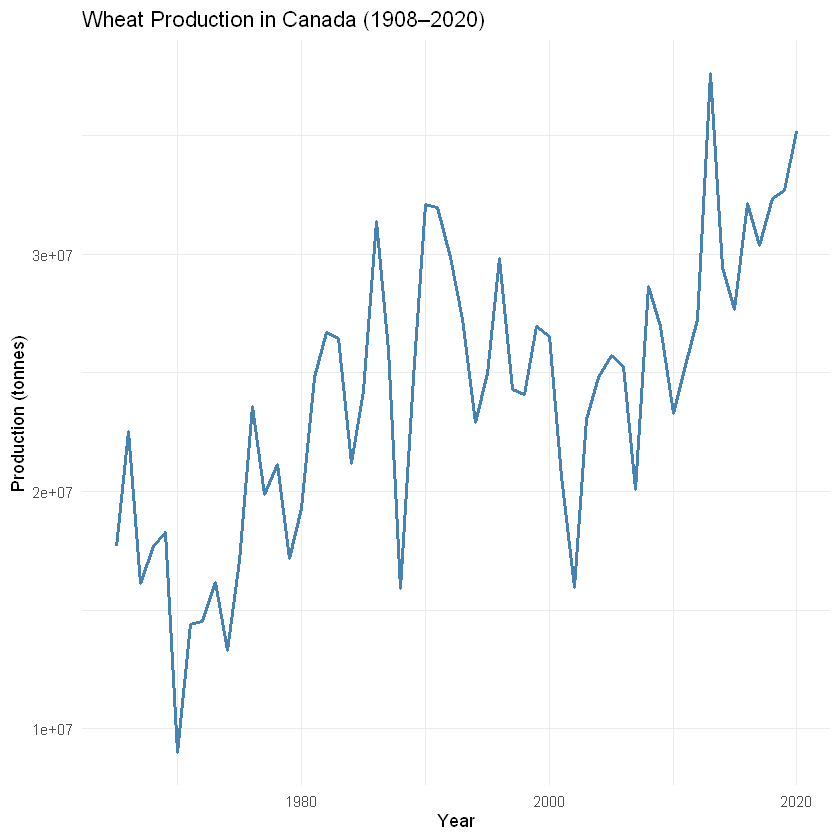

In [21]:
wheat_data <- dbGetQuery(con, "
SELECT YEAR, PRODUCTION FROM CROP_DATA
WHERE CROP_TYPE = 'Wheat' AND GEO = 'Canada'
ORDER BY YEAR")

ggplot(wheat_data, aes(x=YEAR, y=PRODUCTION)) +
  geom_line(color="steelblue", size=1) +
  labs(title="Wheat Production in Canada (1908–2020)",
       x="Year", y="Production (tonnes)") +
  theme_minimal()

# ================================
####  Average yield by province since 2000/ Rendimiento promedio por provincia desde 2000
# ================================

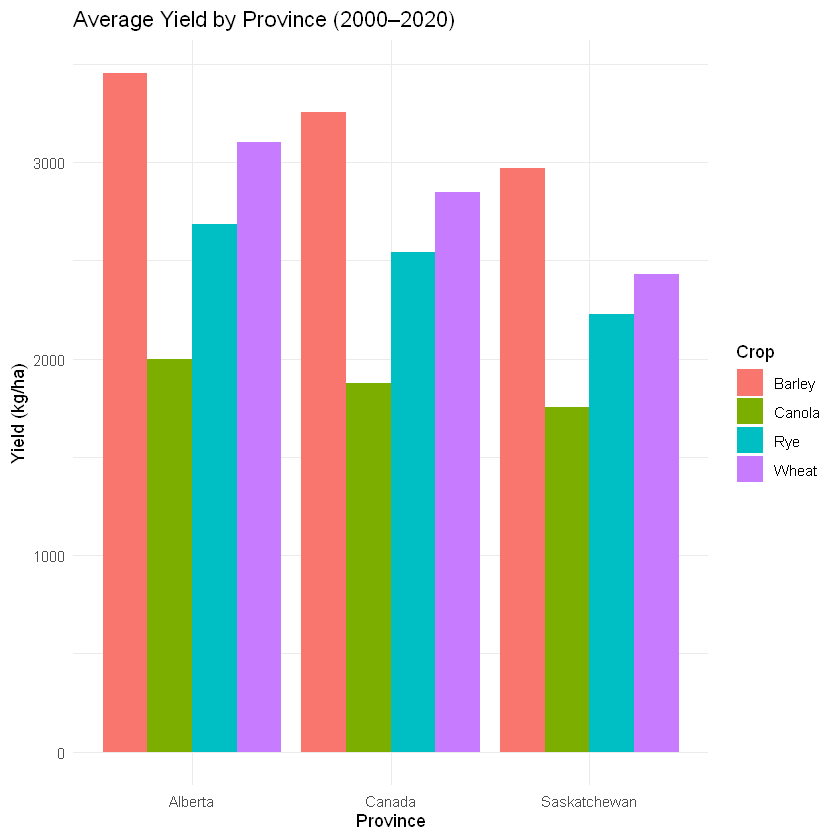

In [19]:
yield_data <- dbGetQuery(con, "
SELECT GEO AS Province, CROP_TYPE AS Crop,
AVG(AVG_YIELD) AS AvgYield
FROM CROP_DATA
WHERE YEAR >= 2000
GROUP BY Province, Crop")

ggplot(yield_data, aes(x=Province, y=AvgYield, fill=Crop)) +
  geom_bar(stat="identity", position="dodge") +
  labs(title="Average Yield by Province (2000–2020)",
       x="Province", y="Yield (kg/ha)") +
  theme_minimal()

# ================================
#### Canola Prices vs. Exchange Rate / Precios de Canola vs Tipo de Cambio
# ================================

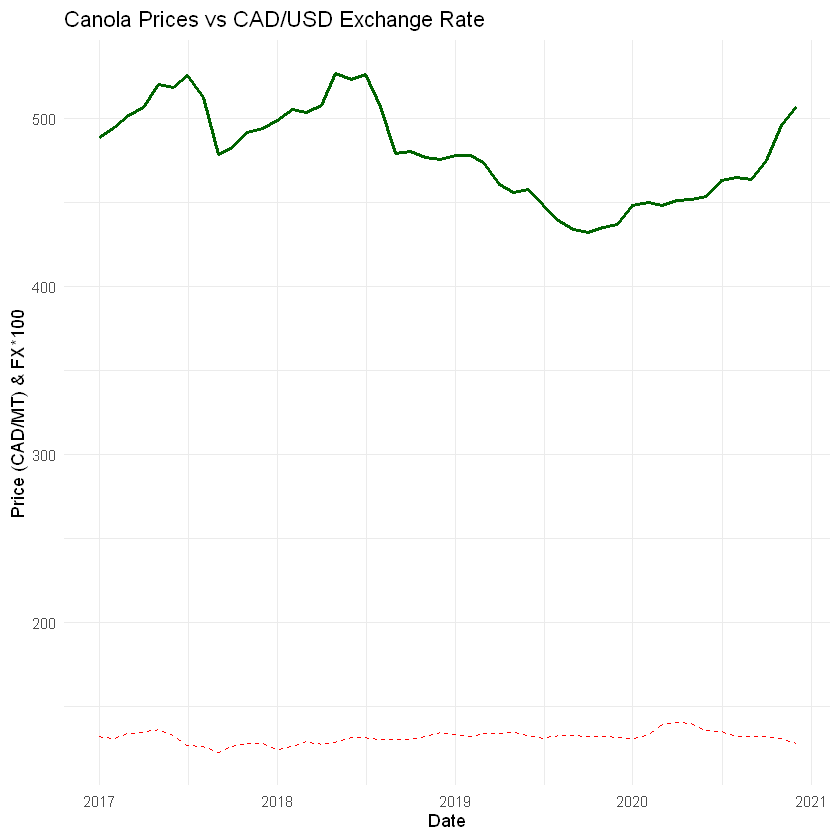

In [20]:
canola_fx <- dbGetQuery(con, "
SELECT fp.DATE, fp.PRICE_PRERMT AS PriceCAD, fx.FXUSDCAD
FROM FARM_PRICES fp
JOIN MONTHLY_FX fx ON fp.DATE = fx.DATE
WHERE fp.CROP_TYPE = 'Canola' AND fp.GEO = 'Saskatchewan'
ORDER BY fp.DATE")

canola_fx$DATE <- as.Date(canola_fx$DATE)

ggplot(canola_fx, aes(x=DATE)) +
  geom_line(aes(y=PriceCAD), color="darkgreen", size=1) +
  geom_line(aes(y=FXUSDCAD*100), color="red", linetype="dashed") +
  labs(title="Canola Prices vs CAD/USD Exchange Rate",
       x="Date", y="Price (CAD/MT) & FX*100") +
  theme_minimal()